In [1]:
print('Continue?(1=YES/0=NO)')
continue_training=0
# continue_training=bool(int(input()))

Continue?(1=YES/0=NO)


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
!pip install -q tensorflow-gpu==2.0.0
import tensorflow as tf
!pip install -q imageio
import glob
import imageio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import PIL
import cv2
import random
import time
import shutil, os
from tensorflow.keras import layers

from IPython import display
from tqdm import tqdm

from google.colab import drive
drive.mount('/gdrive')
# drive.mount("/gdrive", force_remount=True)
path = "/gdrive/My Drive/GAN/"
folder = "VEAGAN/VAEGAN_ELBO"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
size = (64, 64, 3)
imgs = []
files = os.listdir(path+"pokemon/")
random.shuffle(files)
file_range = 10 if len(files)-1 > 4000 else len(files)-1
for i in tqdm(range(0, file_range)):
    img = mpimg.imread(path+"pokemon/"+str(files[i]))
    img = cv2.resize(img, (size[0], size[1]), interpolation = cv2.INTER_AREA)
    imgs.append(img)
    

train_images = np.array(imgs).astype('float32')
# train_images = train_images / 255 # Normalize the images to [0, 1]
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


# plt.imshow(train_images[0, :, :, :])

100%|██████████| 868/868 [00:20<00:00, 42.16it/s]


In [0]:
def make_encoder_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=size, activation='selu', kernel_initializer='lecun_normal'))
    model.add(layers.AlphaDropout(0.1))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation='selu', kernel_initializer='lecun_normal'))
    model.add(layers.AlphaDropout(0.1))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same', activation='selu', kernel_initializer='lecun_normal'))
    model.add(layers.AlphaDropout(0.1))

#     model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same', activation='selu', kernel_initializer='lecun_normal'))
#     model.add(layers.AlphaDropout(0.1))

    model.add(layers.Flatten())
    model.add(layers.Dense(200))
    
    return model

encoder = make_encoder_model()

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, input_shape=(100,), activation='relu', kernel_initializer='lecun_normal'))
    model.add(layers.Reshape((8, 8, 256)))
    model.add(layers.AlphaDropout(0.1))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', activation='selu', kernel_initializer='lecun_normal'))
    model.add(layers.AlphaDropout(0.1))

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='selu', kernel_initializer='lecun_normal'))
    model.add(layers.AlphaDropout(0.1))

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', activation='selu', kernel_initializer='lecun_normal'))
    model.add(layers.AlphaDropout(0.1))

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', activation='linear', kernel_initializer='lecun_normal'))

    return model

generator = make_generator_model()


# mean, logvar = tf.split(encoded, num_or_size_splits=2, axis=1)
# eps = tf.random.normal(shape=mean.shape)
# z = eps * tf.exp(logvar * .5) + mean
# generated_image = generator(z, training=False)

# print(generated_image[0, :, :, :])
# plt.imshow(generated_image[0, :, :, :].numpy())
# plt.imshow((generated_image[0, :, :, :].numpy() * 127.5 + 127.5).astype('int32'))

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3], activation='selu', kernel_initializer='lecun_normal'))
    model.add(layers.AlphaDropout(0.1))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation='selu', kernel_initializer='lecun_normal'))
    model.add(layers.AlphaDropout(0.1))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same', activation='selu', kernel_initializer='lecun_normal'))
    model.add(layers.AlphaDropout(0.1))

#     model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same', activation='selu', kernel_initializer='lecun_normal'))
#     model.add(layers.AlphaDropout(0.1))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

discriminator = make_discriminator_model()


# decision = discriminator(generated_image)
# print (decision)

In [0]:
cross_entropy_logits = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

def regulerizer_loss(z, mean, logvar, generated_images, images):
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=generated_images, labels=images)
    # logpx_z = -tf.reduce_mean(cross_ent, axis=[1, 2, 3])
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy_logits(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy_logits(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    total_loss = cross_entropy_logits(tf.ones_like(fake_output), fake_output)
    return total_loss


generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
all_optimizer = tf.keras.optimizers.Adam(1e-4)#, beta_1=0.5)

In [8]:
EPOCHS = 50000
noise_dim = 100
num_examples_to_generate = 49


    
seed = tf.Variable(tf.random.normal([num_examples_to_generate, noise_dim]))

checkpoint_dir = path + folder +'_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(seed=seed,
                                 step=tf.Variable(0),
                                 generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 all_optimizer=all_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)



if continue_training:
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
    print(checkpoint.step)
    print('Loaded!')
else:
    print(checkpoint.step)
    print('Restarted!')
    try:
        shutil.rmtree(path+folder+'_imgs/')
    except: pass
    os.mkdir(path+folder+'_imgs')
    try:
        shutil.rmtree(path+folder+'_checkpoints/')
    except: pass
    os.mkdir(path+folder+'_checkpoints')

<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0>
Restarted!


In [0]:
Noise = layers.GaussianNoise(1)


@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        mean, logvar = tf.split(encoder(images/255, training=True), num_or_size_splits=2, axis=1)
        eps = tf.random.normal(shape=mean.shape)
        z = eps * tf.exp(logvar * .5) + mean
        generated_images = generator(z, training=True)

        
        generated_images_latent = tf.tanh(generator(noise, training=True))

        
        real_output = discriminator(((images - 127.5) / 127.5), training=True)
        fake_output = discriminator((generated_images_latent), training=True)

        reg_loss  = regulerizer_loss(z, mean, logvar, (generated_images), images/255)
        gen_loss  = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        all_loss  = reg_loss

    # gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables+encoder.trainable_variables)
    # gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gradients_of_all = gen_tape.gradient(all_loss, generator.trainable_variables+encoder.trainable_variables+discriminator.trainable_variables)

    # generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables+encoder.trainable_variables))
    # discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    all_optimizer.apply_gradients(zip(gradients_of_all, generator.trainable_variables+encoder.trainable_variables+discriminator.trainable_variables))
    
    return reg_loss, gen_loss, disc_loss
    
def train(dataset, epochs, start):
    for epoch in range(start, epochs):
        start = time.time()
        total_disc_loss, total_reg_loss, total_gen_loss = [], [], []

        for image_batch in dataset:
            reg_loss, gen_loss, disc_loss = train_step(image_batch)
            total_disc_loss.append(disc_loss)
            total_gen_loss.append(gen_loss)
            total_reg_loss.append(reg_loss)

        # Save the model every 15 epochs
        if (epoch) % 15 == 0:
            checkpoint.step.assign(epoch)
            checkpoint.save(file_prefix = checkpoint_prefix)

            # Produce images for the GIF as we go
            display.clear_output(wait=True)
            generate_and_save_images(generator, epoch + 1, seed)

        print ('Epoch {}: {:.5f} sec\tVAE: {:.5f} GAN: {:.5f} DISC: {:.5f} '.format(epoch + 1, time.time()-start, np.array(total_reg_loss).mean(), np.array(total_gen_loss).mean(), np.array(total_disc_loss).mean()))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [0]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    predictions = tf.tanh(model(test_input, training=False))

    fig = plt.figure(figsize=(7,7))

    for i in range(predictions.shape[0]):
        plt.subplot(7, 7, i+1)
        plt.imshow(np.clip(predictions[i, :, :, :] * 127.5 + 127.5, 0, 1))
        plt.axis('off')

    plt.savefig(path+folder+'_imgs/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

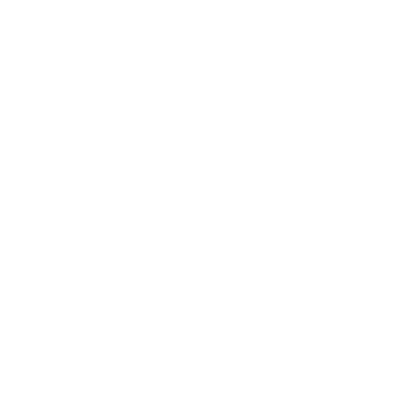

Epoch 271: 5.81445 sec	VAE: 4142.99512 GAN: 0.91272 DISC: 1.62418 
Epoch 272: 3.25494 sec	VAE: 4120.74902 GAN: 0.96096 DISC: 1.57358 
Epoch 273: 3.22246 sec	VAE: 4128.21338 GAN: 0.92578 DISC: 1.56996 
Epoch 274: 3.23291 sec	VAE: 4101.81592 GAN: 0.93273 DISC: 1.54114 
Epoch 275: 3.22882 sec	VAE: 4117.45215 GAN: 0.93495 DISC: 1.62586 
Epoch 276: 3.22020 sec	VAE: 4100.65234 GAN: 0.91936 DISC: 1.57145 
Epoch 277: 3.22825 sec	VAE: 4125.46973 GAN: 0.92460 DISC: 1.61493 
Epoch 278: 3.21584 sec	VAE: 4127.55811 GAN: 0.93606 DISC: 1.62371 
Epoch 279: 3.49244 sec	VAE: 4132.29004 GAN: 0.90345 DISC: 1.62258 
Epoch 280: 3.22938 sec	VAE: 4120.38281 GAN: 0.92250 DISC: 1.63038 
Epoch 281: 3.22450 sec	VAE: 4127.66260 GAN: 0.95042 DISC: 1.59451 
Epoch 282: 3.23171 sec	VAE: 4107.61816 GAN: 0.95074 DISC: 1.55240 
Epoch 283: 3.22474 sec	VAE: 4128.60156 GAN: 0.92972 DISC: 1.60207 
Epoch 284: 3.20250 sec	VAE: 4115.79395 GAN: 0.92251 DISC: 1.59066 


KeyboardInterrupt: ignored

In [11]:
# %%time
train(train_dataset, EPOCHS, checkpoint.step.numpy())

In [0]:
gen_num = 10

test = tf.random.normal([gen_num*gen_num,noise_dim])

predictions = tf.tanh(generator([test]))


fig = plt.figure(figsize=(gen_num,gen_num))

for i in range(predictions.shape[0]):
    plt.subplot(gen_num, gen_num, i+1)
    plt.imshow(predictions[i, :, :, :] * 127.5 + 127.5)
    plt.axis('off')
plt.show()


In [0]:
while True:
    test = tf.random.normal([1,noise_dim])

    predictions = tf.tanh(generator([test]))
    plt.clf()
    plt.imshow(predictions[0, :, :, :] * 127.5 + 127.5)
    plt.axis('off')
    plt.show()
    
    result = tf.sigmoid(discriminator(predictions))
    print(result[0][0])
    
    display.clear_output(wait=True)
    
    if result[0][0] > .9:
        break


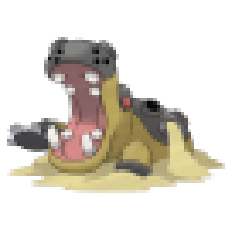

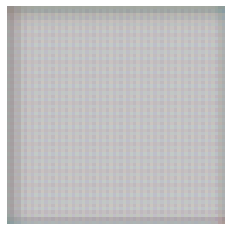

In [12]:
image_index = 1

plt.clf()
plt.imshow(train_images[image_index, :, :, :]/255)
plt.axis('off')
plt.show()

mean, logvar = tf.split(encoder(np.array([train_images[image_index]])), num_or_size_splits=2, axis=1)
eps = tf.random.normal(shape=mean.shape)
z = eps * tf.exp(logvar * .5) + mean
generated_images = tf.sigmoid(generator(z))

plt.clf()
plt.imshow(generated_images[0, :, :, :].numpy())
plt.axis('off')
plt.show()